### Import Neccessary Libraries

In [41]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import requests
from pathlib import Path

### Load Dataset

In [2]:
n_samples = 1000
X, y = make_circles(n_samples,noise=0.03, random_state=42)

In [11]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [3]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [14]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

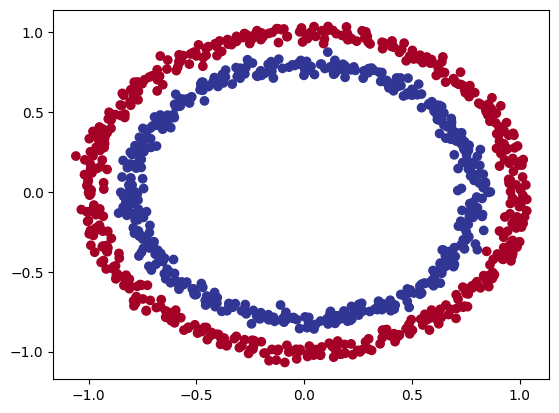

In [20]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### Converting data to tensors

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [26]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]], device='cuda:0'),
 tensor([1., 1., 1., 1., 0.], device='cuda:0'))

the random state kwarg makes the randomness of the split reproducible

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
len(X_train), len(X_test), len(y_train), len(y_test), X_train.device

(800, 200, 800, 200, device(type='cuda', index=0))

### The Model

In [74]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        l1 = self.layer_1(x)
        l1_relu = self.relu(l1)
        l2 = self.layer_2(l1_relu)
        l2_relu = self.relu(l2)
        l3 = self.layer_3(l2_relu)
        logits = l3.squeeze()
        return logits

In [75]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

We can also use the nn.Sequential to create our model.  
THis will perform the forward pass automatically with respect to the order of which the layers are listed

In [35]:
model_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [36]:
model_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### Model Training and its Parameters

In [76]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

A classification model may require less learning rate, (experiment with this)

In [77]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [70]:
y_logits = model_0(X_test.to(device))[:5]

In [71]:
y_pred_probs = torch.sigmoid(y_logits)

In [72]:
y_pred_probs

tensor([0.5427, 0.5437, 0.5459, 0.5353, 0.5435], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [73]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [78]:
torch.manual_seed(42)

epochs = 2001

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train)
    y_logits_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_logits)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_logits_probs = torch.sigmoid(test_logits)
        test_preds = torch.round(test_logits_probs)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 200 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 200 | Loss: 0.68977, Accuracy: 50.00% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 50.00% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 50.00% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 46.75% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 1000 | Loss: 0.56818, Accuracy: 37.88% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1200 | Loss: 0.37056, Accuracy: 41.75% | Test loss: 0.40595, Test acc: 92.00%
Epoch: 1400 | Loss: 0.17180, Accuracy: 18.25% | Test loss: 0.22108, Test acc: 97.50%
Epoch: 1600 | Loss: 0.09123, Accuracy: 5.38% | Test loss: 0.12741, Test acc: 99.50%
Epoch: 1800 | Loss: 0.05773, Accuracy: 2.38% | Test loss: 0.08672, Test acc: 99.50%
Epoch: 2000 | Loss: 0.04176, Accuracy: 1.25% | Test loss: 0.06583, Test acc: 100.00%


In [42]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get(
      "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Result of the Previous Model without the ReLU Layer

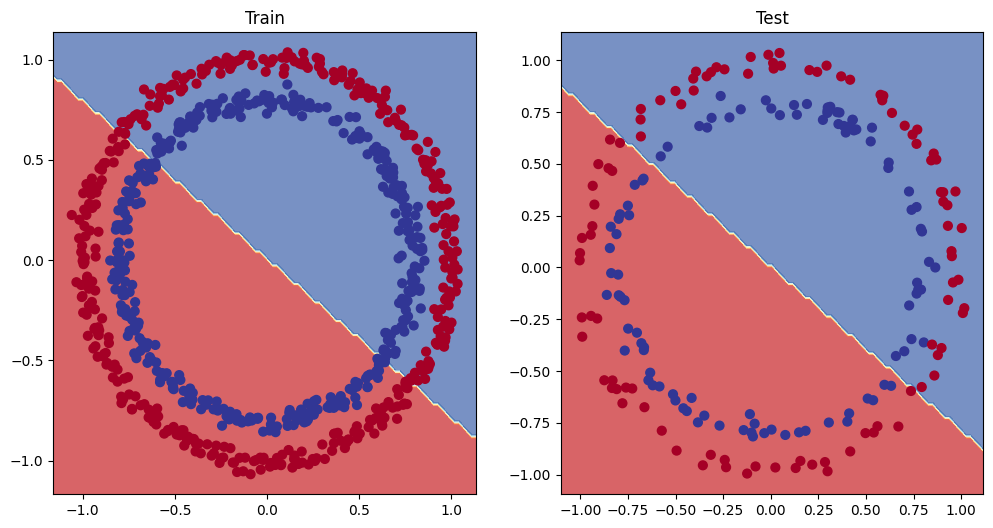

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

With a 50% accuracy, we can tell that our model is underfitting, meaning that it is not learning predictive patterns from our data

even after adding an extra layer and increasing the number the features in the output neurons, we have the same amount of accuracy?

Well, adding a non linear activation function (the best performing one of such is the RELU) can help because clearly, out data is non linear (circular)

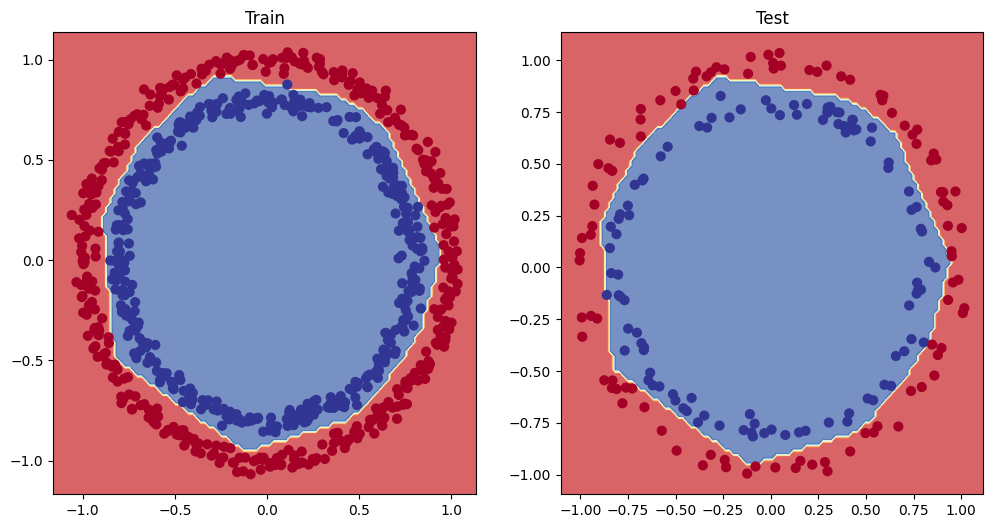

In [59]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)  # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)  # model_3 = has non-linearity